# Lekce 7

Rozhodovací stromy jou dalším z algoritmů, které můžeme používat ke klasifikaci. Jejich obrovskou výhodou je, že jsou velmi snadno interpretovatelné. To znamená, že uživatel může snadno zjistit, proč algoritmus přiřadil záznam k dané skupině.

Scikit-learn umí graf exportovat ve formátu aplikace Graphviz. Pro ni pak existuje modul, který umí vykreslit rozhodovací strom jak obrázek.

- Nejprve je potřeba stáhnout software Graphviz [zde](https://graphviz.org/download/).
- Následně je potřeba nainstalovat modul `pydotplus` příkazem `pip install pydotplus`.

In [1]:
import pandas
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

### Popis importů

* `DecisionTreeClassifier` - klasifikátor využívající algoritmus rozhodovacího strumu, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* `ConfusionMatrixDisplay` - vizualizace matice záměn, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
* `accuracy_score`, `precision_score` a `recall_score` - funkce pro vyhodnocení výsledků modelu, dokumentace je [zde](https://scikit-learn.org/stable/modules/classes.html#classification-metrics)
* `train_test_split` - funkce pro rozdělení dat na trénovací a testovací, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* `GridSearchCV` hledá nejlepší parametry klasifikátoru ze zadaného rozsahu podle zadané metriky, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* `export_graphviz` je funkce pro export rozhodovacího stromu do DOT (software Graphviz) formátu, dokumentace je [zde](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html)
* `StringIO` je objekt, který umožňuje uložení dat do paměti, je s nimi možné pracovat podobně jako se souborem, je přímo součástí jazyka Python, dokumentace je [zde](https://docs.python.org/3/library/io.html).
* `Image` je objekt, který umožní zobrazit data jako obrázek
* `pydotplus` je modul pro komunikaci se software Graphviz (např. vygenerování obrázku), dokumentace je [zde](https://pydotplus.readthedocs.io/)

In [2]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

Budeme pracovat s daty v souboru [mushrooms.csv](mushrooms.csv), která obsahují data o houbách. Náš model bude predikovat, jestli je houba jedlá nebo jedovatá.

In [3]:
data = pandas.read_csv("mushrooms.csv")
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Zde je význam jednotlivých sloupců. V datech nemáme, na rozdíl od předchozích lekcí, číselné hodnoty, ale kategorie. Například tvaru klobouku máme tvar vyjádřený jednou z možných kategorií, např. `b` označuje zvonek, `c` kuželový tvar atd. Nemáme tedy tvar vyjádřený jako číslo (např. nějaký úhel nebo tvar křivky), ale jako jednu z kategorií, do které houba patří.

- **class (třída)**, edible (jedlý)=e, poisonous (jedovatý)=p
- **cap-shape (tvar klobouku)**, bell (zvonek)=b, conical (kuželový)=c, convex (vypouklý)=x, flat (plochý)=f, knobbed (hrbolatý)=k, sunken (prohloubený)=s
- **cap-surface (povrch klobouku)**, fibrous (vláknitý)=f, grooves (žebrovaný)=g, scaly (šupinatý)=y, smooth (hladký)=s
- **cap-color (barva klobouku)**, brown (hnědý)=n, buff (světle žlutý)=b, cinnamon (skořicový)=c, gray (šedý)=g, green (zelený)=r, pink (růžový)=p, purple (fialový)=u, red (červený)=e, white (bílý)=w, yellow (žlutý)=y
- **bruises (modřiny)**, bruises (modřiny)=t, no (ne)=f
- **odor (vůně)**, almond (mandlový)=a, anise (anýzový)=l, creosote (kreosotový)=c, fishy (rybí)=y, foul (zapáchající)=f, musty (zatuchlý)=m, none (žádný)=n, pungent (štiplavý)=p, spicy (kořeněný)=s
- **gill-attachment (připevnění lupenů)**, attached (připevněný)=a, descending (sestupný)=d, free (volný)=f, notched (vykrojený)=n
- **gill-spacing (rozestup lupenů)**, close (blízký)=c, crowded (hustý)=w, distant (vzdálený)=d
- **gill-size (velikost lupenů)**, broad (široký)=b, narrow (úzký)=n
- **gill-color (barva lupenů)**, black (černý)=k, brown (hnědý)=n, buff (světle žlutý)=b, chocolate (čokoládový)=h, gray (šedý)=g, green (zelený)=r, orange (oranžový)=o, pink (růžový)=p, purple (fialový)=u, red (červený)=e, white (bílý)=w, yellow (žlutý)=y
Here is the bullet list with the English names of features, their Czech translations, and the values in English with Czech translations in brackets:
- **stalk-shape (tvar třeně)**, enlarging (rozšiřující se)=e, tapering (zužující se)=t
- **stalk-root (kořen třeně)**, bulbous (bulbovitý)=b, club (kyjovitý)=c, cup (pohárovitý)=u, equal (rovný)=e, rhizomorphs (rizomorfy)=z, rooted (kořenící)=r, missing (chybí)=?
- **stalk-surface-above-ring (povrch třeně nad prstencem)**, fibrous (vláknitý)=f, scaly (šupinatý)=y, silky (hedvábný)=k, smooth (hladký)=s
- **stalk-surface-below-ring (povrch třeně pod prstencem)**, fibrous (vláknitý)=f, scaly (šupinatý)=y, silky (hedvábný)=k, smooth (hladký)=s
- **stalk-color-above-ring (barva třeně nad prstencem)**, brown (hnědý)=n, buff (světle žlutý)=b, cinnamon (skořicový)=c, gray (šedý)=g, orange (oranžový)=o, pink (růžový)=p, red (červený)=e, white (bílý)=w, yellow (žlutý)=y
- **stalk-color-below-ring (barva třeně pod prstencem)**, brown (hnědý)=n, buff (světle žlutý)=b, cinnamon (skořicový)=c, gray (šedý)=g, orange (oranžový)=o, pink (růžový)=p, red (červený)=e, white (bílý)=w, yellow (žlutý)=y
- **veil-type (typ závoje)**, partial (částečný)=p, universal (celkový)=u
- **veil-color (barva závoje)**, brown (hnědý)=n, orange (oranžový)=o, white (bílý)=w, yellow (žlutý)=y
- **ring-number (počet prstenců)**, none (žádný)=n, one (jeden)=o, two (dva)=t
- **ring-type (typ prstence)**, cobwebby (pavučinový)=c, evanescent (mizející)=e, flaring (rozšířený)=f, large (velký)=l, none (žádný)=n, pendant (visící)=p, sheathing (pochvový)=s, zone (zónový)=z
- **spore-print-color (barva výtrusného tisku)**, black (černý)=k, brown (hnědý)=n, buff (světle žlutý)=b, chocolate (čokoládový)=h, green (zelený)=r, orange (oranžový)=o, purple (fialový)=u, white (bílý)=w, yellow (žlutý)=y
- **population (populace)**, abundant (hojný)=a, clustered (shlukující se)=c, numerous (četný)=n, scattered (roztroušený)=s, several (několik)=v, solitary (osamělý)=y
- **habitat (stanoviště)**, grasses (trávy)=g, leaves (listy)=l, meadows (louky)=m, paths (cesty)=p, urban (městské)=u, waste (odpadní)=w, woods (lesy)=d

Aby náš první strom byl co nejjenodušší, budeme na začátku rozdělovat houby pouze podle osti lupenů. Do tabulky `X` tedy vložíme pouze sloupec `gill-size` a do série `y` sloupec `survived`.

In [4]:
# Definování sloupců s vlastnostmi (features)
feature_cols = ["gill-size"]

# Výběr sloupců s vlastnostmi z dat
X = data[feature_cols]
# Výběr cílové proměnné (target variable) z dat
y = data["class"]

Rozhodovací strom si sám o sobě neporadí s textovými zápisy pohlaví, využijeme proto `OneHotEncoder`. Výsledek převedeme na typ pole (`array`) pomocí metody `toarray()`, abychom si mohli prohlédnout výsledek. Pokud bychom si výsledek nechtěli prohlédnout, tento krok můžeme vynechat. Pole je základní datovou strukturou, která je převzatá z modulu `numpy`. Na rozdíl od tabulky v `pandas` je pole poněkud jednodušší strukturou - například neobsahuje index, nepodporuje dotazy a nejde přímo uložit do souboru. Díky jejich jednoduchosti je však práce s poli rychlejší.

Podívejme se nyní na obsah pole `X`. Vidíme, že vy výstupu máme dva sloupce. V každém řádku najdeme vždy jednu hodnotu 0.0 a jednu hodnotu 1.0. Pořadí závisí na tom, jestli je má daná houba lupuny široké nebo úzké.

Ještě než pokročíme dál, je potřeba jedna důležitá poznámka: I předchozí algoritmy (tj. KNN a SVM) by si poradili s kategoriemi, pokud bychom použili `OneHotEncoder`. My ho nepoužívali, protože všechny hodnoty (kromě tříd, do kterých jsme data rozřazovali) byly čísla.

In [5]:
# Vytvoření instance OneHotEncoder
encoder = OneHotEncoder()
# Přizpůsobení a transformace X pomocí OneHotEncoder
X = encoder.fit_transform(X)
# Převod výsledku na pole (array)
X = X.toarray()
# Výstup transformovaného X
X


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

Pole nemá názvy sloupečků. Pokud bychom je ale potřebovali, můžeme je zjistit z proměnné `encoder`, a to pomocí metody `get_feature_names_out()`.

In [6]:
# Získání názvů nových vytvořených vlastností po OneHotEncoder transformaci
encoder.get_feature_names_out()

array(['gill-size_b', 'gill-size_n'], dtype=object)

Název se skládá vždy z názvu původního sloupce a hodnoty, pro kterou se ve sloupci zobrazuje číslo 1.

Data si na testovací a trénovací sadu rozdělíme ručně, protože nevyužíváme `GridSearchCV`.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Dále vytvoříme `DecisionTreeClassifier`, což je klasifikátor využívající algoritmus rozhodovacího stromu. Necháme nastavené výchozí parametry.

In [8]:
# Vytvoření instance DecisionTreeClassifier s náhodným stavem (random_state) nastaveným na 42
clf = DecisionTreeClassifier(random_state=42)
# Trénování modelu
clf = clf.fit(X_train, y_train)
# Predikce (predict) hodnot cílové proměnné (y) pomocí testovacích dat X_test
y_pred = clf.predict(X_test)

Dále vygenerujeme grafický výstup. Využijeme funkci `export_graphviz`. Abychom si obrázek mohli prohlédnout Jupyter notebooku, využijeme následující příkazy. Výsledkem je obrázek, který se zobrazí v Jupyter notebooku.

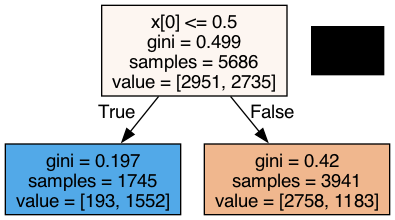

In [9]:
# Vytvoření objektu StringIO, který je jakousi "virtuální" souborovou strukturou v paměti. 
# Tento objekt bude použit pro ukládání struktury rozhodovacího stromu.
dot_data = StringIO()
# Funkce export_graphviz z knihovny sklearn se používá pro konverzi rozhodovacího stromu 
# do DOT formátu, což je grafický jazyk používaný pro popis grafů a stromů. Parametr out_file určuje,
# kam se výsledek uloží - v tomto případě do naší StringIO instance dot_data. Parametr filled=True znamená, 
# že uzly stromu budou vyplněny barvou, což může pomoci vizualizovat hodnoty v uzlech.
export_graphviz(clf, out_file=dot_data, filled=True)
# Tento řádek kódu používá knihovnu pydotplus k převedení DOT dat do formátu, který lze využít pro vytvoření obrázku. 
# Metoda getvalue() naší instance StringIO (dot_data) se používá pro získání celého obsahu jako jednoho řetězce.
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Tento poslední řádek vytváří obrázek stromu ve formátu PNG. Funkce Image pochází z knihovny IPython 
# a slouží pro zobrazení obrázku přímo v notebooku Jupyter. Metoda create_png() na objektu graph generuje samotný obrázek.
Image(graph.create_png())

Pokud Jupyter notebooku nepoužíváme nebo pokud chceme uložit strom jako obrázek (např. pro vložení do blogového článku), příkaz upravíme. Použijeme metodu `write_png()` a jako parametr zadáme jméno souboru, kam chceme obrázek uložit. Přípona souboru by měla být `.png`, což je oblíbený grafický formát pro ukládání obrázků.

In [10]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Uložíme obrázek do souboru
graph.write_png('tree.png')

True

Označení "strom" vychází z části matematiky, která se nazývá *teorie grafů* (*graph theory*). My se jí zabývat nebudeme, ale popíšeme si jeho strukturu a pojmy, které se k jejímu popisu používají.

Nahoře je tzv. vrchol (*root node*), z něhož vychází dvě hrany (*edges*). Tento vrchol má dva potomoky. Ti sami už žádné potomky nemají, vrcholy bez potomků pak značujeme jako listy (*leaf*). Každý z vrcholů (kromě listů) je místem, kde se musíme rozhodnout, kterou z hran budeme pokračovat.

Jednotlivé typy uzlů jsou shrnuty na obrázku níže. Máme tam:

- root node (kořen),
- decision node (rozhodovací vrchol),
- leaf (list).

![A-Sample-Decision-Tree-Visualized-1024x712.png](A-Sample-Decision-Tree-Visualized-1024x712.png)

Rozhodnutí provádíme na základě záznamů, který chceme klasifikovat. V našem případě se rozhodnujeme pouze na základě velikosti lupenů (nic dalšího v datech nemáme). Rozhodujeme se podle prvního řádku popisu uzlu. Zde je ale dost tajemný výraz `X[0] <= 0.5`. Abychom zjistili, co tento výraz znamená, doplnímu do grafu popisku sloupců (`features`) našich dat. Tyto popisky zázkáme od `encoder`, který s nimi manipuloval. Slouží k tomu metoda `get_feature_names_out()`, kterou jsme si už ukazovali. Výsledek volání metody přidáme jako parametr `feature_names` funkci `export_graphviz`.

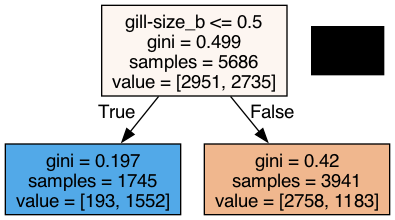

In [11]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [12]:
# Získání seznamu tříd, které byly naučeny klasifikátorem (clf)
clf.classes_

array(['e', 'p'], dtype=object)

Nyní již vidíme, že v kořenu je `gill-size_b` (případně by tam mohl být `gill-size_n`, oba dva sloupce poskytují stejnou informaci). Platí následující dvě skutečnosti:

Pokud je ve sloupci `gill-size_b` hodnota 0, pak není široký, tím pádem musí být úzký. 
Pokud je ve sloupci `gill-size_b` hodnota 1, pak je široký. 

My bychom chtěli houbu se širokým listem, vybíráme tedy variantu `False` (tj. je není, že ve sloupci `gill-size_b` 0, měl tam tedy hodnotou 1). Další vrchol je list, protože nemá pod sebou žádné další potomky. Nyní musíme provést rozhodnutí, do jaké skupiny houbu zařadit. Ve druhém řádku listu vidíme, že hub se širokým listem bylo v trénovacích datech `3941` a v posledním řádku dále vidíme `value = [2758, 1183]`. To jsou počty pozorování dle hodnot výstupní proměnné. Hodnotu `e` výstupní proměnné má 2758 (počet jedlých hub) a hodnotu `p` výstupní proměnné má 1183 vzorků (počet jedovatých hub). Strom tedy u houby se širokými listy predikuje, že je jedlá.

Přehlednost zobrazení zvýší, pokud doplníme parametr `class_names`. Pak uvidíme třídu, kterou rozhodovací strom predikuje, v posledním řádku.

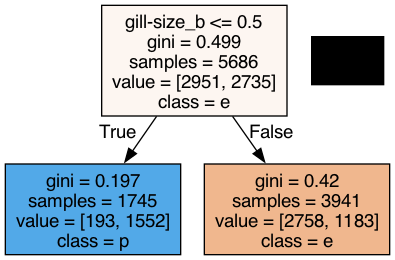

In [13]:
dot_data = StringIO()
export_graphviz(clf, 
                out_file=dot_data, # Soubor, do kterého se uloží výstup ve formátu DOT
                filled=True, # Vyplnění uzlů barvami pro lepší vizualizaci
                feature_names=encoder.get_feature_names_out(), # Názvy vlastností po OneHotEncoder transformaci
                class_names=clf.classes_) # Názvy tříd, které byly naučeny klasifikátorem
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

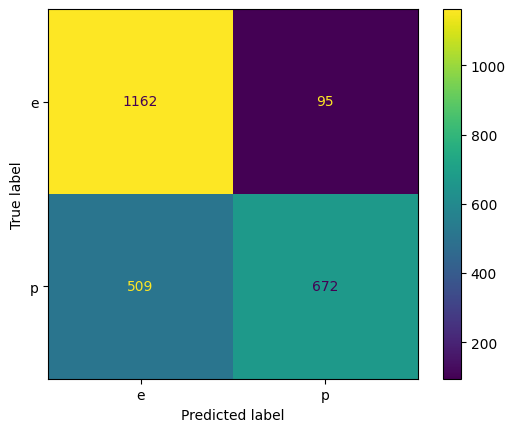

In [14]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

### Čtení na doma - gini

Pokud máme v datech více různých sloupců, modul `scikit-learn` se musí nějak rozhodnout, jak strom vytvořit. Jednou z možností, jak vybrat vhodný sloupec, je koeficient `gini`. Ten je jakýmsi měřítkem "různorodosti" dat v daném uzlu. Například v jednom vrcholu je 193 jedlých a 1552 jedovatých a ve druhém vrcholu je 2758 jedlých a 1183 jedovatých. V jednom z vrcholů tedy v početnější skupině relativně více pozorování než v té méně početné, proto je koeficient gini pro tento rozhodovací vrchol menší.

$$
gini = 1 - \sum(\pi_k^2)
$$

$\pi_k$ je pravděpodobnost, že pozorování patří do skupiny $k$. Vypočítáme ji tak, že vydělíme počet pozorování ve skupině $k$ celkovým počtem pozorování v celém uzlu. Například počet jedovatých v pravém uzlu je 1183 a celkový počet pozorování je (2758 + 1183), pravděpodobnost $\pi = \frac{2758}{2758 + 1183}=0.6999$ (tj. v trénovacím vzorku máme 69.982 % jedovatých hub). Pravděpodobnost pak umocnímě na druhou. Stejný výpočet provedeme pro všechny skupiny, výsledky sečteme a odečteme od 1.

Níže je příklad výpočtu pro pravý list.

In [15]:
2758/(2758+1183)

0.6998223801065719

In [16]:
1 - ((2758/(2758 + 1183)) ** 2 + (1183/(1183 + 2758)) ** 2)

0.4201420328170894

Levý uzel má koeficient výrazně nižší, protože tam je mnohem větší rozdíl mezi počtem jedovatých a jedlých hub. Platí tedy, že tím je Gini koeficient menší, tím lépe, protože rozhodovací uzel dokáže výrazněji oddělit obě skupiny.

In [17]:
1 - ((193 / (193 + 1552)) ** 2 + (1552 / (193 + 1552)) ** 2)

0.19673795781643832

Strom tedy budeme vykreslovat tak, abychom dosáhli co nejnižšího gini koeficientu, což nám zajistí, že rozdíl mezi oběma skupinami bude co největší.

### Přidání dalších sloupců

Nyní do stromu přidáme další proměnnou, pomocí které bude strom predikovat, a to třída, ve které každá z osob cestovala. Vidíme, že strom se docela rozrostl.

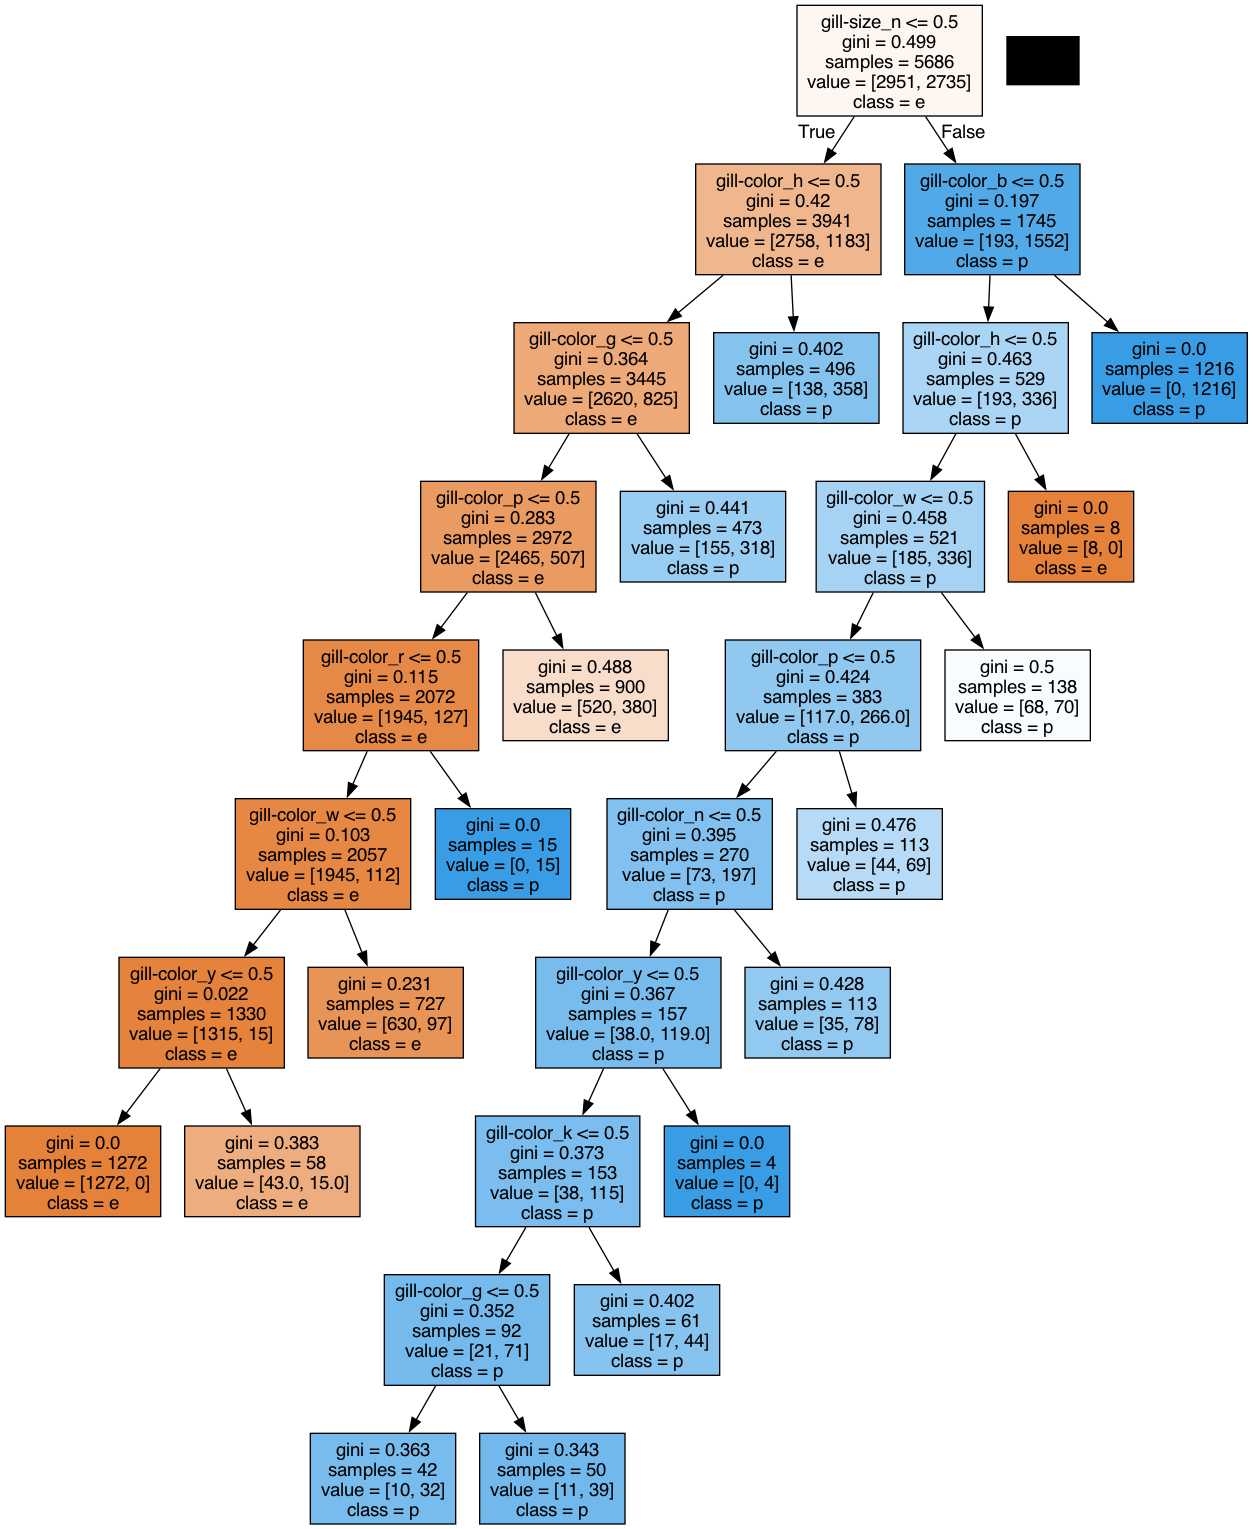

In [18]:
feature_cols = ["gill-size", "gill-color"]

X = data[feature_cols]
y = data["class"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=clf.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

U rozhodovacího stromu můžeme, podobně jako u ostatních algoritmů, nastavovat parametry. U rozhodovacího stromu můžeme měnit tyto:

- `max_depth` = hloubka stromu ("počet pater" stromu),
- `min_samples_split` = minimální počet vzorků pro rozdělení (pokud bude mít vrchol méně, nepůjde dále rozdělit a stane se listem).

Proč tyto parametry řešit?

Výchozí hodnota parametru `max_depth` je `None`, což znamená, že neexistuje žádný limit výška stromu. Strom tak může být velmi komplexní a může vyústit v problém označovaný jako **overfitting** (lze volně přeložit jako "přeučení"). Overfitting je běžný problém v strojovém učení, který nastává, pokud se model příliš dobře přízpůsobí trénovacím datům. To vede k tomu, že model je nedostatečně schopen generalizovat na nová, dosud neviděná data. Overfitting se často projevuje tím, že model má vysokou přesnost na tréninkových datech, ale nízkou přesnost na testovacích datech. Nastavení maximální výšky stromu omezí komplexnost stromu a též může snížit overfitting, protože klasifikace je pak založena na menší kombinaci hodnot jednotlivých sloupců.

Overfitting může omezit též `min_samples_split`, protože brání tomu, aby bylo rozhodnutí činěno na příliš malém množství pozorování. Rozhodnutí založené na jednotkách pozorování může být navázána na příliš specifické vlastnosti trénovací sady dat.

Nejprve zkusíme omezit výšku stromu na 2.

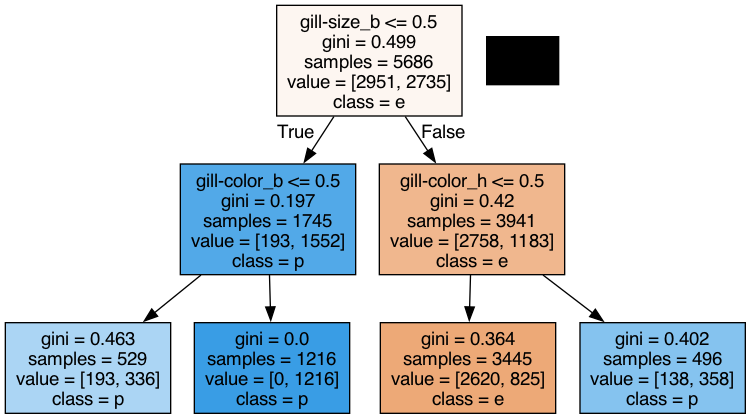

In [19]:
feature_cols = ["gill-size", "gill-color"]

X = data[feature_cols]
y = data["class"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Strom může mít maximálně 2 patra (kořen nepočítáme)
clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=clf.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Následně zkusíme omezit dělení vrcholů na vrcholy o minimálním počtu 200 pozorování.

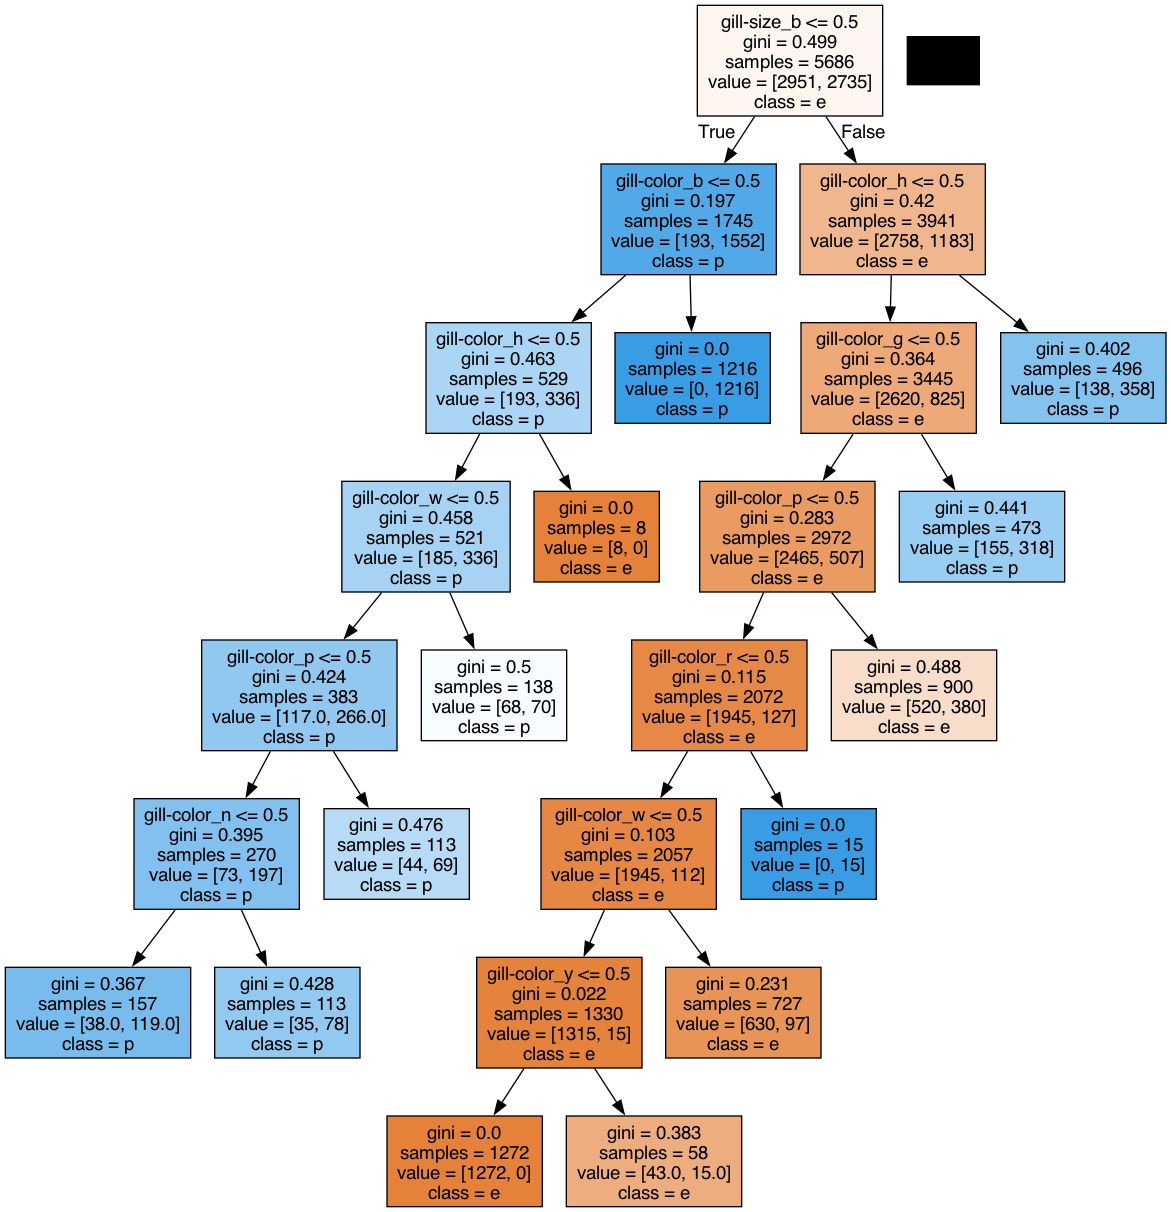

In [20]:
feature_cols = ["gill-size", "gill-color"]

X = data[feature_cols]
y = data["class"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Uzly s méně než 100 vzorky již nejdou rozdělit
clf = DecisionTreeClassifier(min_samples_split=200)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, feature_names=encoder.get_feature_names_out(), class_names=clf.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Kvalitu predikcí takto gigantického stromu můžeme ověřit pomocí matice záměn, která má stejnou strukturu a stejnou interpretaci jako v předchozích lekcí.

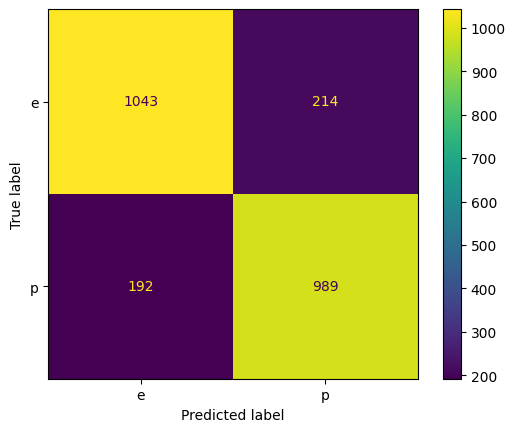

In [21]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Též můžeme spočítat všechny metriky, které jsme si již ukázali.

In [22]:
accuracy_score(y_test, y_pred)

0.8334700574241182

V našem případě nám ale bude více vadit chyba, kdy bychom označili jedovatou houbu za jedlou. Určitě je lepší nechat nějakou jedlou houbu v lese, než sebrat jedovatou a riskovat tak otravu. 

V souladu s best practices bychom jako *positive* měli označit více kritický výsledek. Např. při detekci spamu se obvykle jako positive označuje to, že zpráva je spam, a jako negativní to, že jde o legitimní zprávu. Z toho důvodu bychom měli jako *positive* označit hodnotu "p" (houba je  jedovatá). Na tom sice není nic pozitivního, ale jde o kritický výsledek, který může vyvolat nějaký problém a měl by spustit nějakou akci. Např. u detekce spamtu spustí přesunutí zprávy do spamu, u detekce bankovního podvodu spustí vyšetřování.

Z toho důvodu si vypočítáme metriku *recall*, k tomu můžeme využít funkci `recall_score()`. Protože naše labels jsou `e` a `p`, musíme použít parametr `pos_label`.

In [23]:
recall_score(y_test, y_pred, pos_label="p")

0.8374259102455546

In [24]:
precision_score(y_test, y_pred, pos_label="p")

0.8221113881961762

### Čtení na doma Kombinace číselných a kategoriálních proměnných

V našem datasetu máme i numerický sloupec, který označuje cenu jízdenky. Na tento údaj nepotřebujeme použít `OneHotEncoder()`. Proto vytvoříme dva seznamy sloupců:

- `categorical_columns`, kam uložíme sloupce s kategorickými hodnotami,
- `numeric_columns`, kam uložíme sloupce (resp. sloupec) s numerickými hodnotami.

In [25]:
import numpy

data = pandas.read_csv("titanic.csv")
y = data["survived"]

categorical_columns = ["embarked", "class", "who", "alone"]
numeric_columns = ["fare", "sibsp", "parch"]

Z tabulky `data` vybereme sloupce v seznamu `others` a převedeme je na pole s využitím metody `to_numpy()`. 

In [26]:
others = data[numeric_columns].to_numpy()

Následně sloupce v seznamu `categorical_columns` upravíme pomocí `OneHotEncoder`.

Je to trochu nešťastné, ale metody na převod na matici se jmenují v modulech `scikit-learn` a `pandas` různě.

- V modulu `scikit-learn` používáme metodu `to_numpy()`
- V modulu `pandas` používáme metodu `toarray()`.

In [27]:
ohe = OneHotEncoder()
encoded_columns = ohe.fit_transform(data[categorical_columns])
encoded_columns = encoded_columns.toarray()

In [28]:
type(others)

numpy.ndarray

In [29]:
type(X)

scipy.sparse._csr.csr_matrix

Nakonec obě pole spojíme do jednoho pomocí funkce `numpy.concatenate()`. Tato funkce je jakousi "hloupější" verzí funkce `merge()`, kterou známe z `pandas`. Spojuje dvě matice do jedné na základě čísla řádků, tj. vezme nultý řádek z obou polí a vytvoří z něj jeden dlouhý řádek v nové matici, to samé s prvním řádkem atd.

In [30]:
X = numpy.concatenate([encoded_columns, others], axis=1)

Na konci data opět rozdělíme na trénovací a testovací.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Výsledky rozhodovacího stromu můžeme zobrazit pomocí matice záměn. Ta funguje stejně jako u předchozích algoritmů.

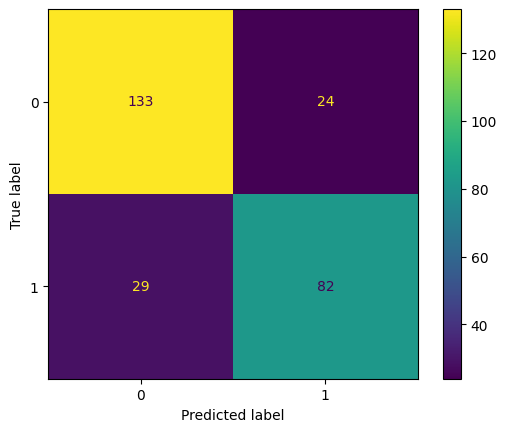

In [32]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

Podobně můžeme určitě i metriky modelu.

In [33]:
accuracy_score(y_test, y_pred)

0.8022388059701493

In [34]:
precision_score(y_test, y_pred)

0.7735849056603774

In [35]:
recall_score(y_test, y_pred)

0.7387387387387387

## Křížová validace a Grid Search

Ukazázali jsme si, že na trénování modelu může mít vliv hodnota jeho některého parametru. Například u algoritmu K Nearest Neighbors jsme zkoušeli nastavit různé hodnoty parametru `n_neighbors` pomocí for cyklu. Když bychom parametrů měli víc, můžeme použít vnořený for cyklus, ale brzy by se nám výsledky špatně porovnávaly. V knihovně `scikit-learn` existuje třída `GridSearchCV`, která nejlepší nastavení parametrů zjistí za nás.

`GridSearchCV` provádí tvz. křížovou validaci (*cross validation*). To znamená, že nerozděluje data na trénovací a testovací pouze jednou, ale vícekrát (ve výchozím nastavení celkem pětkrát). Tím se snaží předejít problému s *overfitting*, o kterém si povíme v dalších lekcích.

`GridSearchCV` tedy postupuje takto:

- pro každý ze zadaných hodnot parametrů provede několik rozdělení na trénovací a testovací data (*split*),
- pro každé rozdělení dat provede trénování modelu a zjistí hodnotu požadované metriky,
- vypočítá průměr zjištěné metriky pro všechna rozdělení dat.

Na základě průměrů metrik pro jednotlivá rozdělení pak vybere nejlepší metriku. Model tedy již není závislý na tom, jak rozdělíme data na testovací a trénovací část.

Výhoda tohoto přístupu je, že nevyžaduje tolik dat ("recykluje" totiž data, která máme k dispozici). Nevýhodou může být časová náročnost, a to zvlášť v případě, že prohledáváme hodně různých parametrů. Další výhodou je, že pomáhá zabránit jevu označovanému jako **overfitting**. Overfitting je situace, kdy je nějaký model dává velice přesné výsledky pro určité trénovací a testovací data, ale špatné výsledky pro nová data. Takový model je příliš zaměřený na specifika testovacích a trénovacích dat a špatně si pak poradí s novými daty.

Alternativou ke `GridSearchCV` je `RandomizedSearchCV`, který nevyhodnocuje všechny kombinace parametrů, ale jen náhodně vygenerovanou podskupinu. Tím pádem je rychlejší, protože nemusí provádět tolik výpočetních operací. Na druhou stranu to ale znamená, že nemusí najít tak dobrou kombinaci parametrů jako`GridSearchCV`.

![81Yoo.png](81Yoo.png)

### Hledání nejlepší parametrů

Ke hledání nejlepší parametrů opět využijeme `GridSearchCV`

In [36]:
data = pandas.read_csv("mushrooms.csv")


X = data.drop(columns="class")
y = data["class"]

encoder = OneHotEncoder()
X = encoder.fit_transform(X)

model = DecisionTreeClassifier()
params = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 10], "min_samples_split": [10, 20, 30, 40]}

clf = GridSearchCV(model, params, scoring="accuracy")
clf.fit(X, y)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 8, 'min_samples_split': 10}
0.9963058734369079


## Zdroje

* [Gini Impurity](https://www.learndatasci.com/glossary/gini-impurity/)
* [Positive and Negative Classes, Explained](https://www.sharpsightlabs.com/blog/positive-and-negative-classes/)
* [Mushroom Classification Using Different Classifiers](https://medium.com/analytics-vidhya/mushroom-classification-using-different-classifiers-aa338c1cd0ff)
* [Decision Tree Classifier with Sklearn in Python](https://datagy.io/sklearn-decision-tree-classifier/)
* [Decision Tree Classification in Python Tutorial](https://www.datacamp.com/tutorial/decision-tree-classification-python)
* [How to tune a Decision Tree?](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)
* [Overfitting and Pruning in Decision Trees — Improving Model’s Accuracy](https://medium.com/nerd-for-tech/overfitting-and-pruning-in-decision-trees-improving-models-accuracy-fdbe9ecd1160)
* [3 Techniques to Avoid Overfitting of Decision Trees](https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09) (v placené části)

# Cvičení

## Rezervace

Vyzkoušej rozhodovací strom na datové sadě o rezervací hotelů ze serveru [Booking.com](https://booking.com) ([hotel_bookings.csv](hotel_bookings.csv)), kterou jsme používali na začátku kurzu. 

Pokud pracuješ s rozhodovacím stromem, neprováděj u číselných hodnot standardizaci. Není totiž nutná, rozhodovací strom uvažuje vždy v každém rozhodovacím uzlu pouze jednou proměnnou, tím pádem ho nikdy nemůže splést 

- Podívej se, kolik je v datech zrušených rezervací a kolik nezrušených.
- V prvním kroku zkus sestavit pouze na základě proměnné `lead_time`, u které bychom (na základě grafů z první lekce) se mohli domnívat, že bude mít vliv na to, jestli bude rezervace zrušená. Omez strop na `max_depth=2`. Nech si graficky zobrazit strom a na základě obrázku odhadni, jestli bude zrušená rezervace udělaná 5, 20, 100 a 300 dní.
- Vytvoř si pro tento strom matici záměn a urči hodnotu metriky `accuracy`.
- Na rozdíl od například datasetu o kostatcích není tento dataset perfektně vyvážený. V realitě se často setkáváme s tzv. nevyváženými datasety (*imbalanced dataset*), kde je dat z jedné skupiny výrazně víc než dat z druhé. Příkladem jsou například podvodné transakce (podvodných transakcí je mnohem méně než těch běžných), kybernetické útoky (útoků je mnohem méně než běžného provozu v síti) atd. V takových případech nemusí být metrika `accuracy` úplně vhodná. Vyzkoušej proto metriku `balanced_accuracy_score`. Níže je popsaný import.

```py
from sklearn.metrics import balanced_accuracy_score
```

- Problém s nevyváženými datasety je, že modelu stačí správně zařadit dostatečné množství hodnot z početnější skupiny. Protože dat v menší skupině je celkově méně, malá úspěšnost v jejich správné identifikaci sníží metriku `accuracy` jen málo. Naopak `balanced_accuracy_score` uvažuje množství dat v jednotlivých skupinách. Méně početné skupiny mají větší váhu, model je tím pádem nucen soustředit se i na ně. Zkus zjistit hodnotu metriky `balanced_accuracy_score`. Funkce se používá stejně jako `accuracy`.

## Bonusy k rezervacím

Nyní do modelu přidej i další sloupce:

- kategorické sloupce: country, market_segment, distribution_channel, arrival_date_month, meal
- číselné sloupce: lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled

Nyní vyzkoušej `GridSearchCV` a najdi optimální hodnotu parametru `min_samples_split` pro možné parametry `[10, 20, 30, 40]`, pro hodnocení použij metriku `accuracy`.

Takto můžeš vytvořit matici s daty.

```py
# Definování seznamu sloupců, které obsahují kategorické hodnoty
# Tyto sloupce budou transformovány pomocí OneHotEncoder na binární (one-hot) reprezentaci
categorical_columns = ["country", "market_segment", "distribution_channel", "arrival_date_month", "meal"]

# Definování seznamu sloupců, které obsahují numerické hodnoty
# Tyto sloupce budou použity přímo v modelu bez další transformace
numeric_columns = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "is_repeated_guest", "previous_cancellations", "previous_bookings_not_canceled"]

# Převod hodnot z numerických sloupců na pole pro další zpracování
others = data[numeric_columns].to_numpy()

# Vytvoření instance OneHotEncoder pro transformaci kategorických hodnot
ohe = OneHotEncoder()

# Přizpůsobení (fit) a transformace dat z kategorických sloupců na binární (one-hot) reprezentaci
encoded_columns = ohe.fit_transform(data[categorical_columns])

# Převod zakódovaných sloupců z formátu sparse matrix na pole pro další zpracování
encoded_columns = encoded_columns.toarray()

# Spojení zakódovaných (kategorických) sloupců a numerických sloupců do jednoho numpy pole (X)
# Použití concatenate pro sloučení podél osy 1 (horizontálně), tj. sloupce se dají vedle sebe
X = np.concatenate([encoded_columns, others], axis=1)
```

Video s řešením je [zde](https://youtu.be/AkwuU7uDAEM).

## Bonus: Poruchy

Vrať se k datům o poruchách ze souboru [predictive_maintenance.csv](predictive_maintenance.csv) a pokus se pomocí rozhodovacího stromu klasifikovat stavy stroje.

Použij sloupce Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min] jako vstupní proměnné a Failure Type jako výstupní proměnnou. Sloupec `Type` obsahuje kategoriální hodnoty, použij teddy `OneHotEncoder`.

Sestav strom, který bude predikovat hodnotu sloupce `Failure Type` - tj. to, jestli dojde k selhání a případně k jakému. Omez hloubku stromu na 5, aby byl strom stále celkem přehledný a mohl být například vložen do servisního manuálu.

Níže máš připravené seznamy sloupců, názvy proměnných odpovídají tomu, co jsme používali v lekci.

```py
categorical_columns = ["Type"]
numeric_columns = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]
```

### Nápověda

Pokud bys chtěl(a) do stromu přidat i názvy features, je to trochu složitější. Je třeba spojit názvy sloupců, které vzešly z `OneHotEncoder`, a názvy numerických sloupců, které jsou původní. Níže je kód který toto provede.

```py
feature_names = list(ohe.get_feature_names_out()) + list(numeric_columns)
feature_names
```

Níže je příklad toho, jak potom použít proměnnou `feature_names` při generování stromu.

```py
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, class_names=clf.classes_, feature_names=feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
```

Video s řešením je [zde](https://youtu.be/K3RU6R-2sGs). Text k oběma příkladům je [zde](reseni.ipynb).

## Další zdroje k imballanced datasetům

- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [5 Techniques to Handle Imbalanced Data For a Classification Problem](https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/)